## Region Proposal Network training example using VGG16 backbone

In [1]:
import os
import numpy as np
import torch
from PIL import Image
import torchvision
import cv2
import matplotlib.pyplot as plt
import utils
import torch.nn as nn
import torch.nn.functional as F
import copy
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

In [2]:
# input image size
ISIZE = (800, 800)

# Imagenet statistics
imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])

## Anchor Box Specs
ratios = [0.5, 1, 2]
anchor_scales = [8, 16, 32]


In [3]:
def create_corner_rect(bb, color='red'):
    bb = np.array(bb, dtype=np.float32)
    return plt.Rectangle((bb[0], bb[1]), bb[2]-bb[0], bb[3]-bb[1], color=color,
                         fill=False, lw=3)
   
def show_corner_bbs(im, bbs):
    #im = np.asarray(im).astype(int).transpose(1,2,0)
    im = np.asarray(im).transpose(1,2,0)
    im = unnormalize(im)
    plt.imshow(im)
    for bb in bbs:
        plt.gca().add_patch(create_corner_rect(bb))    
        
def normalize(im):
    #im = im.astype(np.float32)/255.
    im = im/255.
    """Normalizes images with Imagenet stats."""
    return (im - imagenet_stats[0])/imagenet_stats[1]  

def unnormalize(im):
    im = im.astype(np.float32)
    """Normalizes images with Imagenet stats."""
    im = (im *imagenet_stats[1] +  imagenet_stats[0])*255.
    im = im.astype(np.int)
    return im

def train_val_dataset(dataset, val_split=0.1):
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=val_split)
    datasets = {}
    datasets['train'] = Subset(dataset, train_idx)
    datasets['val'] = Subset(dataset, val_idx)
    return datasets

def evaluate_feature_map(imgs, req_features):
    k = imgs.clone()
    for m in req_features:
        k = m(k)
    return k

def plot_feature_map(k, img_idx, row=64, col=8):
    fig = plt.figure(figsize=(20,160))
    fig.tight_layout()
    for i in range(row):
        for j in range(col):
            ind = i*col + j
            ax = fig.add_subplot(row,col,ind+1,xticks=[],yticks=[])
            ax.imshow(k[img_idx,ind,:,:].detach().cpu()) 
            ax.text(3, 6, ind, fontdict={'weight': 'bold', 'size': 16}, color="y" )
    fig.suptitle("feature map")
    
def plot_imges_with_bboxes(imgs, bboxes, col=4):
    num_imgs = len(imgs)
    row = int(np.ceil(float(len(imgs))/col).item())
    print("row: %s"%row)
    print("imgs: ", num_imgs)
    fig = plt.figure(figsize=(2*col,2*row))
    fig.tight_layout()
    for i in range(row):
        for j in range(col):
            ind = i*col + j
            if ind < num_imgs:
                img = imgs[ind]
                bbs = bboxes[ind]
                img = np.asarray(img).transpose(1,2,0)
                img = unnormalize(img)
                ax = fig.add_subplot(row,col,ind+1,xticks=[],yticks=[])
                ax.imshow(img) 
                for bb in bbs:
                    plt.gca().add_patch(create_corner_rect(bb))
            #ax.text(3, 6, ind, fontdict={'weight': 'bold', 'size': 16}, color="y" )
    fig.suptitle("Images")
    
def pred_bbox_to_xywh(bbox, anchors):
    print("bbox: ", bbox.shape)
    print("anchors: ", anchors.shape)
    anc_height = anchors[:, 2] - anchors[:, 0]
    anc_width = anchors[:, 3] - anchors[:, 1]
    anc_ctr_y = anchors[:, 0] + 0.5 * anc_height
    anc_ctr_x = anchors[:, 1] + 0.5 * anc_width

    bbox_numpy = bbox.detach().cpu().data.numpy()
    dy = bbox_numpy[:, 0::4]
    dx = bbox_numpy[:, 1::4]
    dh = bbox_numpy[:, 2::4]
    dw = bbox_numpy[:, 3::4]
    ctr_y = dy * anc_height[:, np.newaxis] + anc_ctr_y[:, np.newaxis]
    ctr_x = dx * anc_width[:, np.newaxis] + anc_ctr_x[:, np.newaxis]
    h = np.exp(dh) * anc_height[:, np.newaxis]
    w = np.exp(dw) * anc_width[:, np.newaxis]

    roi = np.zeros(bbox_numpy.shape, dtype=h.dtype)
    roi[:, 0::4] = ctr_y - 0.5 * h
    roi[:, 1::4] = ctr_x - 0.5 * w
    roi[:, 2::4] = ctr_y + 0.5 * h
    roi[:, 3::4] = ctr_x + 0.5 * w

    return roi

In [5]:
def bbox_generation(images, targets, X_FM, Y_FM):
    global ratios
    global anchor_scales
    num_batch = len(images)
    X_IMG, Y_IMG = images[0].shape[1:]
    bbox_all = [item['boxes'] for item in targets]
    labels_all = [item['labels'] for item in targets]
    
    #imgs_torch_all = torch.stack([item for item in images])
    #if is_cuda:
    #    imgs_torch_all = imgs_torch_all.cuda()   
    #k = imgs_torch_all.clone()
    #for m in req_features:
    #    k = m(k)
    #print(k.shape) 
    

    sub_sampling_x = int(X_IMG/X_FM)
    sub_sampling_y = int(Y_IMG/Y_FM)
    #print(X_IMG, Y_IMG, X_FM, Y_FM, sub_sampling_x,sub_sampling_y)
    anchor_base = np.zeros((len(ratios)*len(anchor_scales), 4), dtype=np.float32)
    
    ctr_x = np.arange(sub_sampling_x, (X_FM+1) * sub_sampling_x, sub_sampling_x)
    ctr_y = np.arange(sub_sampling_y, (Y_FM+1) * sub_sampling_y, sub_sampling_y)
    index = 0
    ctr = np.zeros((len(ctr_y)*len(ctr_y),2),dtype=np.float32)
    for x in range(len(ctr_x)):
        for y in range(len(ctr_y)):
            ctr[index, 1] = ctr_x[x] - 8
            ctr[index, 0] = ctr_y[y] - 8
            index +=1 
            
    anchors = np.zeros((X_FM * Y_FM * 9, 4))
    index = 0
    for ctr_y, ctr_x in ctr:
        for i in range(len(ratios)):
            for j in range(len(anchor_scales)):
                h = sub_sampling_x * anchor_scales[j] * np.sqrt(ratios[i])
                w = sub_sampling_y * anchor_scales[j] * np.sqrt(1./ ratios[i])
                anchors[index, 0] = ctr_y - h / 2.
                anchors[index, 1] = ctr_x - w / 2.
                anchors[index, 2] = ctr_y + h / 2.
                anchors[index, 3] = ctr_x + w / 2.
                index += 1
    #print(anchors.shape)    
    
    index_inside = np.where(
        (anchors[:, 0] >= 0) &
        (anchors[:, 1] >= 0) &
        (anchors[:, 2] <= Y_IMG) &
        (anchors[:, 3] <= X_IMG)
    )[0]
    #print(index_inside.shape)
    
    label = np.empty((len(index_inside), ), dtype=np.int32)
    label.fill(-1)
    valid_anchors = anchors[index_inside]
    #print(label.shape, valid_anchors.shape)
    #print(valid_anchors[0])  
    
    ious_all = []
    for bx in bbox_all:
        ious = np.empty((len(label), bx.size()[0]), dtype=np.float32)
        ious.fill(0)
        for num1, i in enumerate(valid_anchors):
            ya1, xa1, ya2, xa2 = i  
            anchor_area = (ya2 - ya1) * (xa2 - xa1)
            for num2, j in enumerate(bx):
                yb1, xb1, yb2, xb2 = j
                box_area = (yb2- yb1) * (xb2 - xb1)
                inter_x1 = max([xb1, xa1])
                inter_y1 = max([yb1, ya1])
                inter_x2 = min([xb2, xa2])
                inter_y2 = min([yb2, ya2])
                if (inter_x1 < inter_x2) and (inter_y1 < inter_y2):
                    iter_area = (inter_y2 - inter_y1) * (inter_x2 - inter_x1)
                    iou = iter_area / (anchor_area+ box_area - iter_area)            
                else:
                    iou = 0.
                ious[num1, num2] = iou
        ious_all.append(ious)
        
        
    gt_argmax_ious_all = []
    gt_max_ious_all = []
    for ious_ in ious_all:
        gt_argmax_ious = ious_.argmax(axis=0)
        gt_max_ious = ious_[gt_argmax_ious, np.arange(ious_.shape[1])]
        gt_argmax_ious_all.append(gt_argmax_ious)
        gt_max_ious_all.append(gt_max_ious)
    #print(gt_argmax_ious_all)  
    #print(gt_max_ious_all)   
    
    argmax_ious_all = []
    max_ious_all = []
    for ious_ in ious_all:
        argmax_ious = ious_.argmax(axis=1)
        max_ious = ious_[np.arange(len(label)), argmax_ious]
        argmax_ious_all.append(argmax_ious)
        max_ious_all.append(max_ious)
    #print(argmax_ious_all)    
    #print(max_ious_all)  
    
    gt_argmax_ious_all = []
    for gt_max_ious_, ious_ in zip(gt_max_ious_all, ious_all):
        gt_argmax_ious = np.where(ious_ == gt_max_ious_)[0]
        gt_argmax_ious_all.append(gt_argmax_ious)
    #print(gt_argmax_ious_all)       

    pos_iou_threshold  = 0.7
    neg_iou_threshold = 0.3  
    
    label_all = []
    for n in range(num_batch):
        l = copy.deepcopy(label)
        l[max_ious_all[n] < neg_iou_threshold] = 0
        l[gt_argmax_ious_all[n]] = 1
        l[max_ious_all[n] >= pos_iou_threshold] = 1
        label_all.append(l)
    #print ("label_all 0 and 1: ", sum(label_all[0]), sum(label_all[1]))     
    
    pos_ratio = 0.5
    n_sample = 256
    n_pos = int(pos_ratio * n_sample)
    #print(n_pos)    
    
    for n in range(num_batch):
        #print(np.sum((label_all[n] == 1)))
        pos_index = np.where(label_all[n] == 1)[0]
        #print(pos_index)
        if len(pos_index) > n_pos:
            disable_index = np.random.choice(pos_index, size=(len(pos_index) - n_pos), replace=False)
            label_all[n][disable_index] = -1
        #print(np.sum((label_all[n] == 1)))  

        n_neg = n_sample - np.sum(label_all[n] == 1)
        neg_index = np.where(label_all[n] == 0)[0]
        if len(neg_index) > n_neg:
            disable_index = np.random.choice(neg_index, size=(len(neg_index) - n_neg), replace = False)
            label_all[n][disable_index] = -1
        #print(np.sum((label_all[n] == 0)))   
        
        
    max_iou_bbox_all = []
    #print(bbox_all)
    for n in range(num_batch):
        max_iou_bbox_all.append(bbox_all[n][argmax_ious_all[n]])
    #print(max_iou_bbox_all[0].shape, max_iou_bbox_all[0].shape)           
        
    #Anchor box
    height = valid_anchors[:, 2] - valid_anchors[:, 0]
    width = valid_anchors[:, 3] - valid_anchors[:, 1]
    ctr_y = valid_anchors[:, 0] + 0.5 * height
    ctr_x = valid_anchors[:, 1] + 0.5 * width
    #Ground truth
    base_height_all = []
    base_width_all = []
    base_ctr_y_all = []
    base_ctr_x_all = []
    for n in range(num_batch):
        base_height = max_iou_bbox_all[n][:, 2] - max_iou_bbox_all[n][:, 0]
        base_width = max_iou_bbox_all[n][:, 3] - max_iou_bbox_all[n][:, 1]
        base_ctr_y = max_iou_bbox_all[n][:, 0] + 0.5 * base_height
        base_ctr_x = max_iou_bbox_all[n][:, 1] + 0.5 * base_width
        base_height_all.append(base_height)
        base_width_all.append(base_width)
        base_ctr_y_all.append(base_ctr_y)
        base_ctr_x_all.append(base_ctr_x)

    #print(width[2], base_width_all[0][2])        
        
    #Prevent devide by 0
    eps = np.finfo(height.dtype).eps
    height = np.maximum(height, eps)
    width = np.maximum(width, eps)

    #d_{} calculatrion
    anchor_locs_all = []
    for n in range(num_batch):
        dy = (base_ctr_y_all[n].numpy() - ctr_y) / height
        dx = (base_ctr_x_all[n].numpy() - ctr_x) / width
        dh = np.log(base_height_all[n].numpy()/ height)
        dw = np.log(base_width_all[n].numpy() / width)
        anchor_locs_all.append(np.vstack((dy, dx,dh, dw)).transpose())
    #print(anchor_locs_all[0][1], anchor_locs_all[0].shape)        
        
    anchor_labels_all = []
    for n in range(num_batch):
        anchor_labels = np.empty((len(anchors),), dtype=label_all[n].dtype)
        anchor_labels.fill(-1)
        anchor_labels[index_inside] = label_all[n]
        anchor_labels_all.append(anchor_labels)
    anchor_labels_all_merge = np.stack(anchor_labels_all, 0)    
    #print(sum(anchor_labels_all[0]==1), anchor_labels_all[0][0:11])
    #print(anchor_labels_all_merge.shape)
    #print(sum(anchor_labels_all_merge[0]==1))    
    
    anchor_locations_all = []
    for n in range(num_batch):
        anchor_locations = np.empty((len(anchors), anchors.shape[1]), dtype=anchor_locs_all[n].dtype)
        anchor_locations.fill(0)
        anchor_locations[index_inside, :] = anchor_locs_all[n]
        anchor_locations_all.append(anchor_locations)
    #print(anchor_locations_all[0].shape)   
    #print(type(anchor_locations_all[0]))
    anchor_locations_all_merge = np.stack(anchor_locations_all, 0)
    #print(anchor_locations_all_merge[0][0])
    #print(anchor_locations_all[0][1500])    
  
    return anchor_locations_all_merge, anchor_labels_all_merge, anchors


In [6]:
is_cuda= False
if torch.cuda.is_available():
    is_cuda = True
print(is_cuda)  

True


In [11]:
class PennFudanDataset(object):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        img = img.resize(ISIZE)
        img = np.array(img)
        img = normalize(img)
        img = img.transpose(2,0,1)
        img = torch.as_tensor(img, dtype=torch.float32)
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)
        mask = mask.resize(ISIZE)
        # convert the PIL Image into a numpy array
        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
        #print('********************:  ', idx, img.shape)
        #print('target: ', target['labels'])
        return img, target

    def __len__(self):
        return len(self.imgs)

In [12]:
dataset = PennFudanDataset('../../Data/PennFudanPed', None)

datasets = train_val_dataset(dataset)
print(len(datasets['train']))
print(len(datasets['val']))


data_loader = torch.utils.data.DataLoader(datasets['train'], batch_size=15, shuffle=True, num_workers=2, collate_fn=utils.collate_fn)
data_loader_val = torch.utils.data.DataLoader(datasets['val'], batch_size=15, shuffle=True, num_workers=2, collate_fn=utils.collate_fn)

FileNotFoundError: [WinError 3] The system cannot find the path specified: '../../Data/PennFudanPed\\PNGImages'

In [8]:
model = torchvision.models.vgg16(pretrained=True).cuda()
if is_cuda:
    model.cuda() 
model.eval()    
for param in model.features.parameters():
    param.requires_grad = False   
    
fe = list(model.features)
    
req_features = []
for j, i in enumerate(fe[0:30]):
    req_features.append(i)
#print (req_features)

In [9]:
def train_epocs(req_features, model, optimizer, train_dl, val_dl, epochs=10,  rpn_lambda=10):
    for epoch in range(epochs):
        model.train()
        total = 0
        sum_loss = 0
        sum_loss_cls = 0
        sum_loss_loc = 0
        idx = 0
        for images, targets in train_dl:
            idx += 1
            num_batch =  len(images) 
            print("######### %s epoch: %s" %(idx, epoch))
            imgs_torch_all = torch.stack([item for item in images])
            if is_cuda:
                imgs_torch_all = imgs_torch_all.cuda()   
            k = imgs_torch_all.clone()
            for m in req_features:
                k = m(k)
            #print("##############   feature map shape: ", k.shape) 
            X_FM, Y_FM = k.shape[2:]
            #print("##############  X_FM, Y_FM: ",  X_FM, Y_FM )
            anchor_locations_all_merge, anchor_labels_all_merge, anchors = bbox_generation(images, targets, X_FM, Y_FM)
            
            pred_anchor_locs, pred_cls_scores, objectness_score = model(k)

            rpn_loc_all = pred_anchor_locs.view(1,-1,4).squeeze(0)
            rpn_score_all = pred_cls_scores.view(1,-1,2).squeeze(0)
            #print(rpn_loc_all.shape, rpn_score_all.shape)
            gt_rpn_loc_all = torch.from_numpy(anchor_locations_all_merge.astype(np.float32)).view(1,-1,4).squeeze(0)
            gt_rpn_score_all = torch.from_numpy(anchor_labels_all_merge.astype(np.float32)).view(1,-1).squeeze(0)
            if is_cuda:
                gt_rpn_loc_all = gt_rpn_loc_all.cuda()
                gt_rpn_score_all = gt_rpn_score_all.cuda()
            #print(rpn_loc_all.shape, rpn_score_all.shape, gt_rpn_loc_all.shape, gt_rpn_score_all.shape)
            
            #print(rpn_score_all.shape, gt_rpn_score_all.shape)
            rpn_cls_loss_all = F.cross_entropy(rpn_score_all, gt_rpn_score_all.long(), ignore_index = -1)
            #print(rpn_cls_loss_all)
            
            pos_all = gt_rpn_score_all > 0
            mask_all = pos_all.unsqueeze(1).expand_as(rpn_loc_all)
            #print(pos_all.shape, pos_all.unsqueeze(1).shape, rpn_loc_all.shape,  pos_all.unsqueeze(1).expand_as(rpn_loc_all).shape) 
            num_valid_loc_all = 0
            for i, j in enumerate(pos_all):
                if j.item() == True:
                    num_valid_loc_all += 1
            #print (num_valid_loc_all)              
            
            
            mask_loc_preds_all = rpn_loc_all[mask_all].view(-1, 4)
            #print(mask_loc_preds_all.shape)
            mask_loc_targets_all = gt_rpn_loc_all[mask_all].view(-1, 4)
            #print(mask_loc_preds_all.dtype, mask_loc_targets_all.dtype,gt_rpn_loc_all.dtype )        
            
            x_all = torch.abs(mask_loc_targets_all - mask_loc_preds_all)
            rpn_loc_loss_all = ((x_all < 1).float() * 0.5 * x_all**2) + ((x_all >= 1).float() * (x_all-0.5))
            #print(rpn_loc_loss_all.sum())            
            
            N_reg_all = (gt_rpn_score_all >0).float().sum()
            rpn_loc_loss_all = rpn_loc_loss_all.sum() / N_reg_all
            rpn_loss_all = rpn_cls_loss_all + (rpn_lambda * rpn_loc_loss_all)
            #print(rpn_cls_loss_all, rpn_loc_loss_all, rpn_loss_all)   
            
            optimizer.zero_grad()
            rpn_loss_all.backward()
            optimizer.step()
            
            total += num_batch
            sum_loss += rpn_loss_all.item()
            sum_loss_cls += rpn_cls_loss_all.item()
            sum_loss_loc += (rpn_lambda * rpn_loc_loss_all).item()
        train_loss = sum_loss/total
        train_loss_cls = sum_loss_cls/total
        train_loss_loc = sum_loss_loc/total
        if (epoch+1) % 5 == 0:
            torch.save(model.state_dict(), './rpn_%s.pth'%epoch)
        print("train_loss %.3f cls_loss %.3f loc_loss %.3f" % (train_loss, train_loss_cls, train_loss_loc))

    return model

In [10]:
def validate(model, data_loader):
    images,targets = next(iter(data_loader))
    
    img, target = images[0], targets[0]
    bbox = target['boxes']
    labels = target['labels']
    print("bbox: ", bbox)
    print("labels: ", labels)
    print("imageid %s"%target['image_id'])
    print (img.shape)
    X_IMG, Y_IMG = img.shape[1:]
    
    img_all = images
    bbox_all = [item['boxes'] for item in targets]
    labels_all = [item['labels'] for item in targets]

    show_corner_bbs(img_all[1], bbox_all[1])
    
    
    num_batch =  len(images) 
    
    imgs_torch_all = torch.stack([item for item in images])
    if is_cuda:
        imgs_torch_all = imgs_torch_all.cuda()   
    k = imgs_torch_all.clone()
    for m in req_features:
        k = m(k)
    #print("##############   feature map shape: ", k.shape) 
    X_FM, Y_FM = k.shape[2:]
    anchor_locations_all_merge, anchor_labels_all_merge, anchors = bbox_generation(images, targets, X_FM, Y_FM)
            
    pred_anchor_locs, pred_cls_scores, objectness_score = model(k)
    print(pred_anchor_locs.shape, pred_cls_scores.shape, objectness_score.shape)
    print(objectness_score[0,1])
    max_score = pred_cls_scores.argmax(1)
    max_ = objectness_score.argmax(1)
    print (max_score)
    print(max_)
    top_bbox = []
    for ind, item in enumerate(max_):
        print(item.item())
        print(pred_anchor_locs[ind,item.item()])
        roi = pred_bbox_to_xywh(pred_anchor_locs[ind], anchors)
        print (roi.shape)
        print("index: %s bbox: %s "%(ind, roi[item]))
        top_bbox.append([roi[item]])
    #plot_imges_with_bboxes(images, bbox_all)   
    plot_imges_with_bboxes(images, top_bbox)   

In [11]:
class RPN(nn.Module):
    
    def __init__(self, in_channels=512, mid_channels=512, n_anchor=9):
        super(RPN, self).__init__()   
        self.mid_channels = mid_channels
        self.in_channels = in_channels # depends on the output feature map. in vgg 16 it is equal to 512
        self.n_anchor = n_anchor # Number of anchors at each location
        self.conv1 = nn.Conv2d(self.in_channels, self.mid_channels, 3, 1, 1)
        self.reg_layer = nn.Conv2d(mid_channels, n_anchor *4, 1, 1, 0)
        self.cls_layer = nn.Conv2d(mid_channels, n_anchor *2, 1, 1, 0) 
        
        # conv sliding layer
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv1.bias.data.zero_()
        # Regression layer
        self.reg_layer.weight.data.normal_(0, 0.01)
        self.reg_layer.bias.data.zero_()
        # classification layer
        self.cls_layer.weight.data.normal_(0, 0.01)
        self.cls_layer.bias.data.zero_()
        
    def forward(self, k):
        bat_num = k.shape[0]
        x = self.conv1(k)
        pred_anchor_locs = self.reg_layer(x)
        pred_cls_scores = self.cls_layer(x)
        
        pred_anchor_locs = pred_anchor_locs.permute(0, 2, 3, 1).contiguous().view(bat_num, -1, 4)
        pred_cls_scores = pred_cls_scores.permute(0, 2, 3, 1).contiguous()
        objectness_score = pred_cls_scores.view(bat_num, 50, 50, 9, 2)[:, :, :, :, 1].contiguous().view(bat_num, -1)
        pred_cls_scores  = pred_cls_scores.view(bat_num, -1, 2)
        
        return pred_anchor_locs, pred_cls_scores, objectness_score

In [12]:
model = RPN()
if is_cuda:
    model = model.cuda()
parameters = model.parameters()
optimizer = torch.optim.Adam(parameters, lr=0.0015)

In [13]:
model = train_epocs(req_features, model, optimizer, data_loader, None, epochs=20)

######### 1 epoch: 0
######### 2 epoch: 0
######### 3 epoch: 0
######### 4 epoch: 0
######### 5 epoch: 0
######### 6 epoch: 0
######### 7 epoch: 0
######### 8 epoch: 0
######### 9 epoch: 0
######### 10 epoch: 0
######### 11 epoch: 0
train_loss 0.691 cls_loss 0.038 loc_loss 0.653
######### 1 epoch: 1
######### 2 epoch: 1
######### 3 epoch: 1
######### 4 epoch: 1
######### 5 epoch: 1
######### 6 epoch: 1
######### 7 epoch: 1
######### 8 epoch: 1
######### 9 epoch: 1
######### 10 epoch: 1
######### 11 epoch: 1
train_loss 0.254 cls_loss 0.017 loc_loss 0.237
######### 1 epoch: 2
######### 2 epoch: 2
######### 3 epoch: 2
######### 4 epoch: 2
######### 5 epoch: 2
######### 6 epoch: 2
######### 7 epoch: 2
######### 8 epoch: 2
######### 9 epoch: 2
######### 10 epoch: 2
######### 11 epoch: 2
train_loss 0.145 cls_loss 0.012 loc_loss 0.134
######### 1 epoch: 3
######### 2 epoch: 3
######### 3 epoch: 3
######### 4 epoch: 3
######### 5 epoch: 3
######### 6 epoch: 3
######### 7 epoch: 3
######### 8 e

In [14]:
#model.load_state_dict(torch.load('./rpn_4.pth'))
#model.eval()

In [ ]:
validate(model, data_loader)

bbox:  tensor([[ 47.,  74., 188., 756.],
        [164., 100., 320., 768.],
        [587., 141., 778., 752.],
        [410., 303., 583., 680.]])
labels:  tensor([1, 1, 1, 1])
imageid tensor([106])
torch.Size([3, 800, 800])
torch.Size([15, 22500, 4]) torch.Size([15, 22500, 2]) torch.Size([15, 22500])
tensor(-0.5251, device='cuda:0', grad_fn=<SelectBackward>)
tensor([[10128, 15247],
        [10200, 19991],
        [18256, 15013],
        [14170,  9757],
        [ 5593, 15211],
        [19674,  8443],
        [ 6669,  7516],
        [18756, 13654],
        [21072, 19720],
        [ 8469, 14032],
        [ 9462, 16256],
        [13990, 19127],
        [11304, 10172],
        [10624, 12052],
        [13089, 16984]], device='cuda:0')
tensor([15247, 19991, 15013,  9757, 15211,  8443,  7516, 13654, 19720, 14032,
        16256, 19127, 10172, 12052, 16984], device='cuda:0')
15247
tensor([-0.0009, -0.1830, -0.1132,  0.5431], device='cuda:0',
       grad_fn=<SelectBackward>)
bbox:  torch.Size([2250

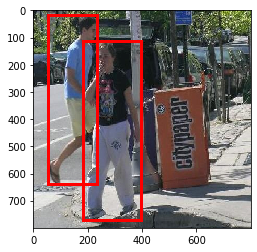

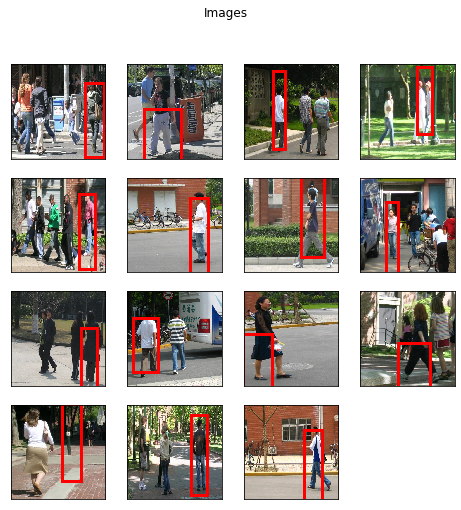

In [15]:
validate(model, data_loader_val)